2017 Edition

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

In [1]:
import time
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [2]:
from pyspark import SparkContext

In [2]:
#ZOE
sc

<SparkContext master=spark://spark-master0-64610-prod:7077 appName=pyspark-shell>

In [3]:
#LOCAL MACHINE
sc =SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: %.2f sec" % (time.time() - time_start))
print(words.take(5))

Runtime: 147.59 sec
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [3]:
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

#df = sqlContext.read.text("../datasets/Gutenberg/txt/Charles Dickens___Life And Adventures Of Martin Chuzzlewit.txt")
# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: {}s".format(time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 95.5356433391571s


<div class="alert alert-success">
  <strong>Answer:</strong><br>
  After running both DataFrame API and the RDD approach, we concluded that DataFrame API runs much faster.
  <br>
  RDD approach facilicates Java serialization by default which introduces some overheads to runtime. It requires both data and its structure to be sent in order to perform the serilisation, plus creating and destroying individual objects require more complex operations for java garbage collector. 
  <br>
  On the other hand, DataFrame API functions with the concept of 'schemas' that describe the structure and only allow the data to be apssed between nodes without the structure requirements like the Java serilization. Also, SparkSQL includes preimplemented optimisation operations that actually optimise the code before executing it, thus making it work much faster in the end. 
    <br>
    Small  note: The dataframe approach counts space as a word because of the regex inside the split.
</div>

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an RDD[String]. We need to transform it to RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)] then call a function to create a DataFrame from the new RDD. Please note that, package com.databricks.spark.csv can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [4]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)
df = sqlContext.read.load('/datasets/airline/1994.csv', 
#df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [11]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that CRSDepTime to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [4]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()


df.printSchema()


root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [10]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [14]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

<div class="alert alert-success">
  We group by all night flights by their carriers and count the flights then collect their sum.<br>
  Carrier DL has 208224 night flights which is the most highest number, whereas AS with 25010 is the least one.
</div>

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

In [16]:
df.describe()

DataFrame[summary: string, year: string, month: string, day_of_month: string, day_of_week: string, scheduled_departure_time: string, scheduled_arrival_time: string, arrival_delay: string, distance: string, src_airport: string, dest_airport: string, carrier: string]

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [15]:
print ("There are",len(df.groupBy(df.src_airport).count().collect()), "origin airports")
print ("There are",len(df.groupBy(df.dest_airport).count().collect()), "destination airports")

There are 224 origin airports
There are 225 destination airports


<div class="alert alert-warning">
  <strong>Our own queation:</strong> What are the 10 most common/favorite flight routes and the least common flight routes?
</div>

In [18]:
print ("Most Favorite flight routes:")
display(df.groupBy(df.src_airport, df.dest_airport).count().orderBy('count', ascending=0).limit(10).collect())

print ("Least Favorite flight routes: (lots of 1 counts here so not much to learn)")
display(df.groupBy(df.src_airport, df.dest_airport).count().orderBy('count', ascending=1).limit(10).collect())

Most Favorite flight routes:


[Row(src_airport='SFO', dest_airport='LAX', count=17526),
 Row(src_airport='LAX', dest_airport='SFO', count=17428),
 Row(src_airport='LAX', dest_airport='PHX', count=13303),
 Row(src_airport='PHX', dest_airport='LAX', count=13250),
 Row(src_airport='ORD', dest_airport='MSP', count=13231),
 Row(src_airport='MSP', dest_airport='ORD', count=13149),
 Row(src_airport='LAX', dest_airport='LAS', count=13056),
 Row(src_airport='LAS', dest_airport='LAX', count=12644),
 Row(src_airport='PHX', dest_airport='LAS', count=11593),
 Row(src_airport='LAS', dest_airport='PHX', count=11375)]

Least Favorite flight routes: (lots of 1 counts here so not much to learn)


[Row(src_airport='MSP', dest_airport='LAN', count=1),
 Row(src_airport='PHX', dest_airport='PSP', count=1),
 Row(src_airport='JFK', dest_airport='LGA', count=1),
 Row(src_airport='IAD', dest_airport='JFK', count=1),
 Row(src_airport='ONT', dest_airport='SNA', count=1),
 Row(src_airport='LIT', dest_airport='SAT', count=1),
 Row(src_airport='MSP', dest_airport='HNL', count=1),
 Row(src_airport='ONT', dest_airport='LGB', count=1),
 Row(src_airport='OKC', dest_airport='SAT', count=1),
 Row(src_airport='IND', dest_airport='IAD', count=1)]

<div class="alert alert-success">
  <strong>Answer:</strong> Looks like San Francisco - Los Angeles airport was the most favorite route. Followed by; <br>
  Los angeles to San Fran back flight of #1 and to Phoenix Sky Harbor airport. <br>
  (We had the feeling that these 3-4 airports will be the most busiest airports when we answer the next questions about it.)
</div>

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [22]:
time_start = time.time()
print ('Method 1: Using group by results count:')
print ("There are",len(df.groupBy(df.carrier).count().collect()), "distinct carriers")
print ("Which are: ")
for row in df.groupBy(df.carrier).count().collect():
    print (row[0], "with", row[1], " flights")
    
print("Method 1: runtime {}s".format(time.time() - time_start))
time_start = time.time()    

print ('\nMethod 2: Using distinct select:')
print ("There are",len(df.select('carrier').distinct().collect()), "distinct carriers")
print ("Which are: ")
for row in df.select('carrier').distinct().collect():
    print (row[0])
print("Method 2: runtime {}s".format(time.time() - time_start))

Method 1: Using group by results count:
There are 10 distinct carriers
Which are: 
UA with 638750  flights
AA with 722277  flights
NW with 482798  flights
HP with 177851  flights
TW with 258205  flights
DL with 874526  flights
US with 857906  flights
AS with 117475  flights
CO with 484834  flights
WN with 565426  flights
Method 1: runtime 2.9122366905212402s

Method 2: Using distinct select:
There are 10 distinct carriers
Which are: 
UA
AA
NW
HP
TW
DL
US
AS
CO
WN
Method 2: runtime 2.743699789047241s


<div class="alert alert-success">
  We used 2 different methods to do this. <br>
  First operation collects the carriers and their flight counts as well to show us. Whereas the second solution only distinct selects the carriers and not their flight counts. The second one runs faster as it doesnt have to reduce back the count of flights but gives less information in the end. It all is about what we need and how fast we need it.<br>
  If we dont need the flight counts, the optimal solution will be the distinct select (2nd one)
</div>

### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [23]:
nightflights = df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)]
print ("There are " , nightflights.count() ,"night flights which is", 100 * nightflights.count() / float(df.count()), "% of all flights!")

There are  1121918 night flights which is 21.658447952605844 % of all flights!


In [10]:
print ("Example late night departure times:")
display(nightflights.select('scheduled_departure_time').distinct().orderBy('scheduled_departure_time', ascending=0).limit(10).collect())

print ("Example early morning departure times:(still earlier than 06:00)")

display(nightflights.select('scheduled_departure_time').distinct().orderBy('scheduled_departure_time', ascending=1).limit(10).collect())

Example late night departure times:


[Row(scheduled_departure_time=2400),
 Row(scheduled_departure_time=2359),
 Row(scheduled_departure_time=2357),
 Row(scheduled_departure_time=2356),
 Row(scheduled_departure_time=2355),
 Row(scheduled_departure_time=2354),
 Row(scheduled_departure_time=2352),
 Row(scheduled_departure_time=2350),
 Row(scheduled_departure_time=2345),
 Row(scheduled_departure_time=2344)]

Example early morning departure times:(still earlier than 06:00)


[Row(scheduled_departure_time=1),
 Row(scheduled_departure_time=2),
 Row(scheduled_departure_time=4),
 Row(scheduled_departure_time=5),
 Row(scheduled_departure_time=6),
 Row(scheduled_departure_time=7),
 Row(scheduled_departure_time=10),
 Row(scheduled_departure_time=11),
 Row(scheduled_departure_time=12),
 Row(scheduled_departure_time=15)]

## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


In [22]:
df.groupBy(df.month).count().orderBy('month', ascending=1).collect()

[Row(month=1, count=423861),
 Row(month=2, count=386954),
 Row(month=3, count=435516),
 Row(month=4, count=420995),
 Row(month=5, count=436432),
 Row(month=6, count=426490),
 Row(month=7, count=443736),
 Row(month=8, count=451086),
 Row(month=9, count=430861),
 Row(month=10, count=449369),
 Row(month=11, count=428227),
 Row(month=12, count=446521)]

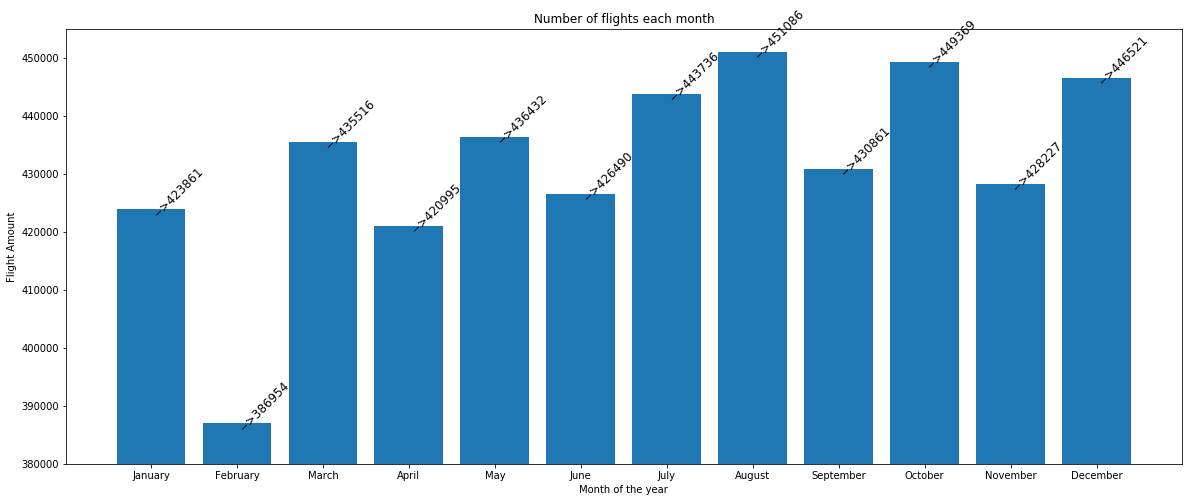

In [9]:
import calendar
fig, ax = plt.subplots(figsize=(20, 8))
style = dict(size=12, color='black', rotation=45)

indices = []
frequencies = []

for row in df.groupBy(df.month).count().orderBy('month', ascending=1).collect():
    frequencies.append(row[1])
    indices.append(calendar.month_name[row[0]])
    ax.text(calendar.month_name[row[0]], row[1]+6000, str('-->'+ str(row[1])), **style)

plt.bar(indices,frequencies, align="center")
axes = plt.gca()
axes.set_ylim([380000,455000])
plt.title("Number of flights each month")
plt.xlabel("Month of the year")
plt.ylabel("Flight Amount")
plt.show()

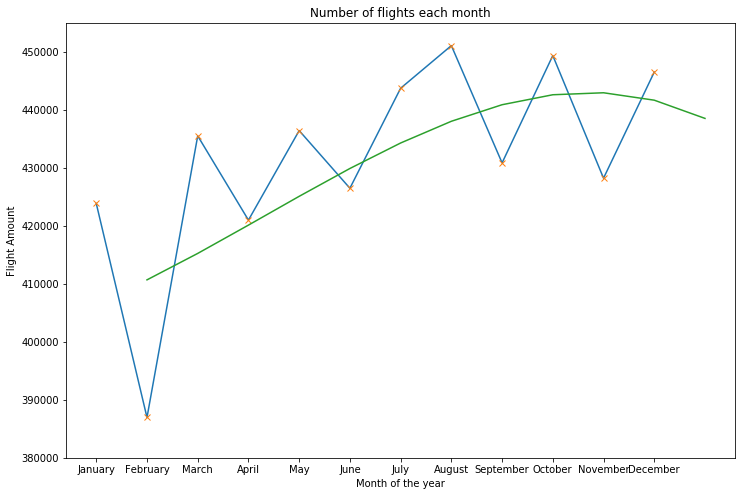

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))


p = np.poly1d(np.polyfit(range(1,13), frequencies, 3))

axes = plt.gca()
axes.set_ylim([380000,455000])
plt.title("Number of flights each month")
plt.xlabel("Month of the year")
plt.ylabel("Flight Amount")

plt.plot(indices,frequencies)
plt.plot(indices, frequencies, 'x', range(1,13), p(range(1,13)), '-')
plt.show()


<div class="alert alert-success">
When we fit a 2nd degree polynomial function into the graph we can see that, there are less flights during winter. However, as the year ends on December we can't see exactly the change after december to the next january. 

Therefore, we decided to merge 2 year's data together. This way we can see if there is an important change between the end of the year to the beginning of the next.
</div>

In [27]:
two_yeardata = frequencies[:]
two_yeardata.extend(frequencies)
two_yearindices = indices[:]
two_yearindices.extend(indices)

for idx in range(len(two_yearindices)):
    if(idx<12):
        two_yearindices[idx] = str("1st-") + two_yearindices[idx]
    if(idx>=12):
        two_yearindices[idx] = str("2nd-") + two_yearindices[idx]

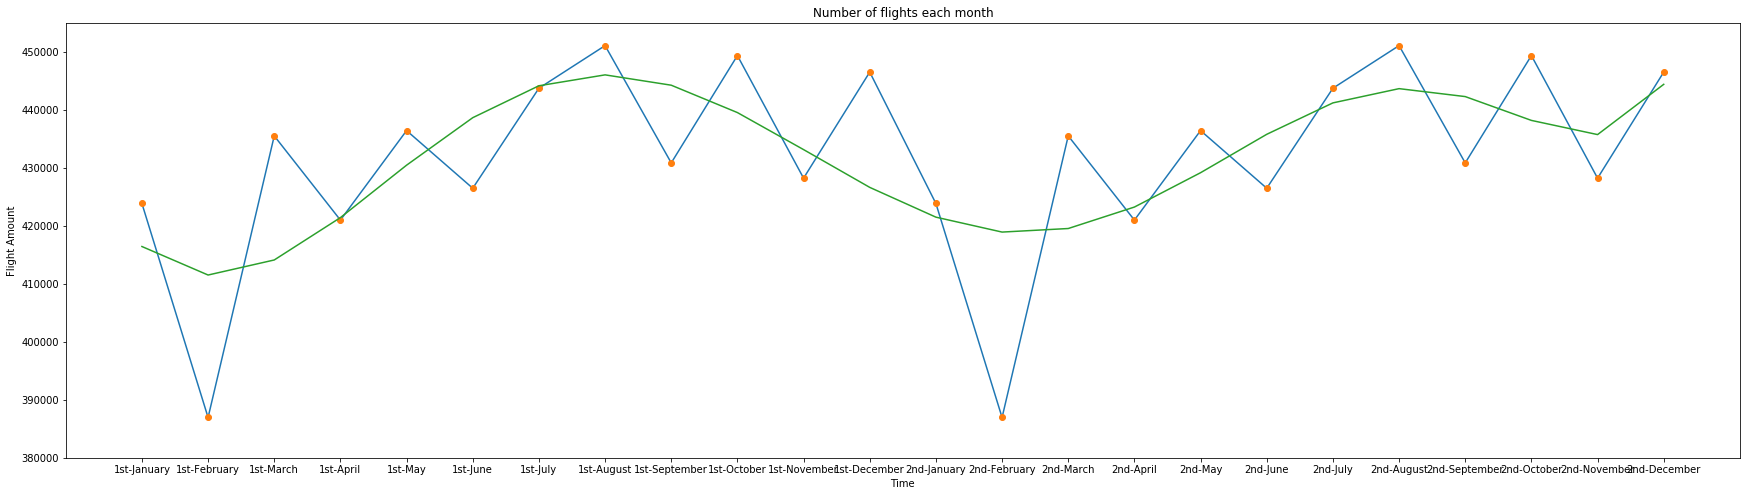

In [129]:
fig, ax = plt.subplots(figsize=(30, 8))
style = dict(size=12, color='black', rotation=45)
axes = plt.gca()
axes.set_ylim([380000,455000])
plt.title("Number of flights each month")
plt.xlabel("Time")
plt.ylabel("Flight Amount")

p_new = np.poly1d(np.polyfit(range(1,25), two_yeardata, 7))


plt.plot(two_yearindices,two_yeardata)

plt.plot(two_yearindices, two_yeardata, 'o', 
         two_yearindices, p_new(range(1,25)), '-')

plt.show()

<div class="alert alert-success">
We were right! After december towards next year's february, the flight count decreases much much more than anytime else during the year. The change is more visible when we put Y-LIMIT to 38K-45K and focus only on that area zoomed in. Fitting a very high degree polynom would actually fit better for the given data, but will terribly fail when we go out of the X boundries used for regression.
<br>
Let us show how terribly the regression we showed for year1 will fail when we try to fit it on the upcoming years.
</div>

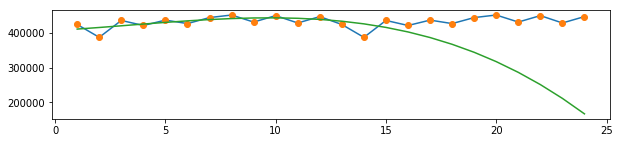

In [119]:
fig = plt.subplots(figsize=(10, 2))
plt.plot(range(1,25),two_yeardata)
plt.plot(range(1,25), two_yeardata, 'o', range(1,25), p(range(1,25)), '-')
plt.show()

<div class="alert alert-success">
  Absolutely terrible. We believe if we merge 10 years or so together and fit a curve into that longer period of time, it would actually fit to the upcoming years after 10+ much better.
</div>

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

In [42]:
df.groupBy(df.day_of_week).count().orderBy('day_of_week', ascending=1).collect()

[Row(day_of_week=1, count=754636),
 Row(day_of_week=2, count=756532),
 Row(day_of_week=3, count=756864),
 Row(day_of_week=4, count=751537),
 Row(day_of_week=5, count=751531),
 Row(day_of_week=6, count=695245),
 Row(day_of_week=7, count=713703)]

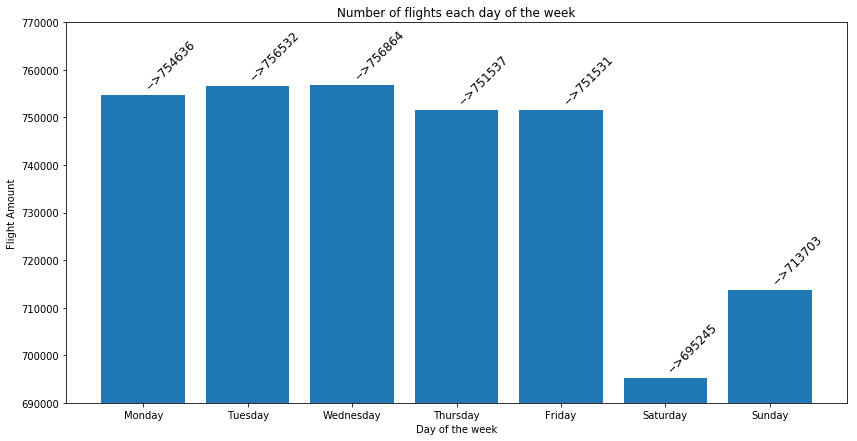

In [28]:
import calendar
fig, ax = plt.subplots(figsize=(14, 7))
style = dict(size=12, color='black', rotation=45)

indices = []
frequencies = []

for row in df.groupBy(df.day_of_week).count().orderBy('day_of_week', ascending=1).collect():
    frequencies.append(row[1])
    indices.append(calendar.day_name[row[0]-1])
    ax.text(calendar.day_name[row[0]-1], row[1]+10000, str('-->'+ str(row[1])), **style)

plt.bar(indices,frequencies, align="center")
axes = plt.gca()
axes.set_ylim([690000,770000])
plt.title("Number of flights each day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Flight Amount")
plt.show()

<div class="alert alert-success">
We always thought the exact opposite would be the case. But apperantly, there are less flights during the weekends. The more you know!
    <br>
    Also the Y-axis is fixed to lower and upper bound, so the values of weekend is not 10% of the other days as it looks like on the graph.
</div>

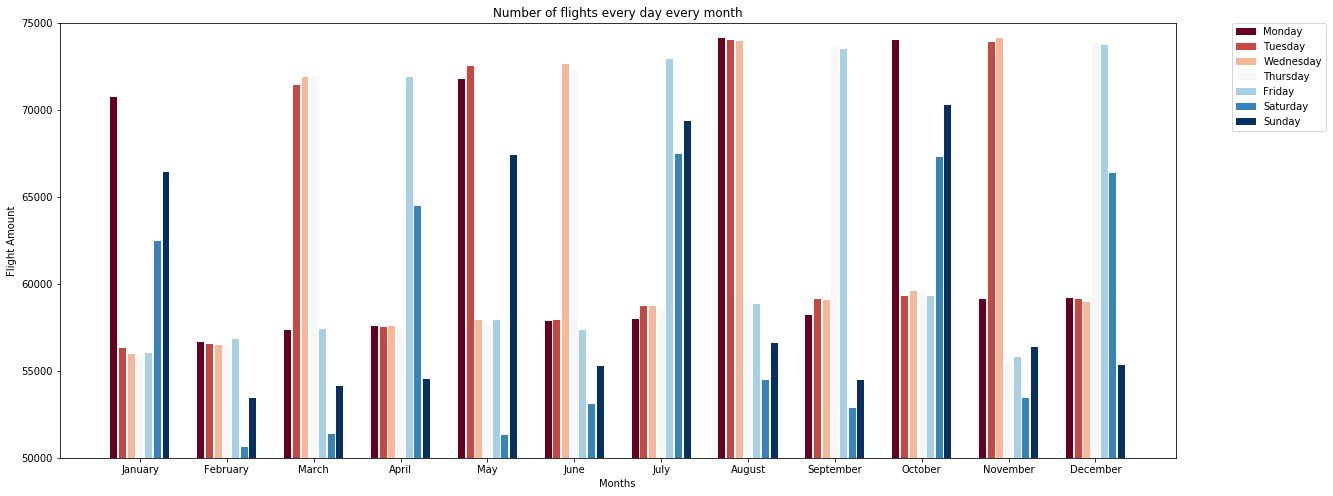

In [24]:
import calendar
from matplotlib import cm
months = [calendar.month_name[x+1] for x in range(12)]
days_of_week = [calendar.day_name[x] for x in range(7)]
colors = cm.RdBu(np.linspace(0, 1, 7))

days_count = df.groupBy(df.month, df.day_of_week).count().orderBy(df.month, df.day_of_week).collect()

width = 0.1

fig, ax = plt.subplots(figsize=(20,8))

for d in range(len(days_of_week)):
    data_values = []
    for m in range(len(months)):
        data_values.append(days_count[m*len(days_of_week)+d][2])
    plt.bar([p + width*d for p in list(range(len(months)))], data_values, width-0.02, color=colors[d])
ax.set_ylim([50000,75000]) 
plt.title("Number of flights every day every month")
plt.xlabel("Months")
plt.ylabel("Flight Amount")
ax.set_xticks([p+ width*3 for p in list(range(len(months)))])
ax.set_xticklabels(months)


plt.legend(days_of_week, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

<div class="alert alert-success">
From the first plot, we can see that the days with less flights are saturday and sunday. But when we see in the second plot, that gives us the variation between each month and each week of the day, we can see that the volume of flights on weekend is not always the lowest, it is the case for some months, like february, march april and september. And we can see that the weekend can represent high number of flights like in october and july. 
A lot of variation happens, it is related to various factors, saison, vacations, and also the countries.
The global view does not give us a representative overview of the flighs, we should take into account different factors to understand the variation.
</div>


In [47]:
print("Cell to test different months and days for further analysis: (For us to practise)")

print("\nTest 1: February flights per day")
display(df[df.month==2].groupBy(df.month, df.day_of_week).count().orderBy('month','day_of_week' , ascending=1).collect())

print("\nTest 2: Sunday flight counts per month")
display(df[df.day_of_week == 7].groupBy(df.month, df.day_of_week).count().orderBy('month','day_of_week' , ascending=1).collect())

Cell to test different months and days for further analysis: (For us to practise)

Test 1: February flights per day


[Row(month=2, day_of_week=1, count=56645),
 Row(month=2, day_of_week=2, count=56549),
 Row(month=2, day_of_week=3, count=56460),
 Row(month=2, day_of_week=4, count=56421),
 Row(month=2, day_of_week=5, count=56823),
 Row(month=2, day_of_week=6, count=50611),
 Row(month=2, day_of_week=7, count=53445)]


Test 2: Sunday flight counts per month


[Row(month=1, day_of_week=7, count=66430),
 Row(month=2, day_of_week=7, count=53445),
 Row(month=3, day_of_week=7, count=54147),
 Row(month=4, day_of_week=7, count=54522),
 Row(month=5, day_of_week=7, count=67412),
 Row(month=6, day_of_week=7, count=55270),
 Row(month=7, day_of_week=7, count=69363),
 Row(month=8, day_of_week=7, count=56615),
 Row(month=9, day_of_week=7, count=54492),
 Row(month=10, day_of_week=7, count=70302),
 Row(month=11, day_of_week=7, count=56393),
 Row(month=12, day_of_week=7, count=55312)]

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.
Plot  bar charts, and interpret your figures.
</div>

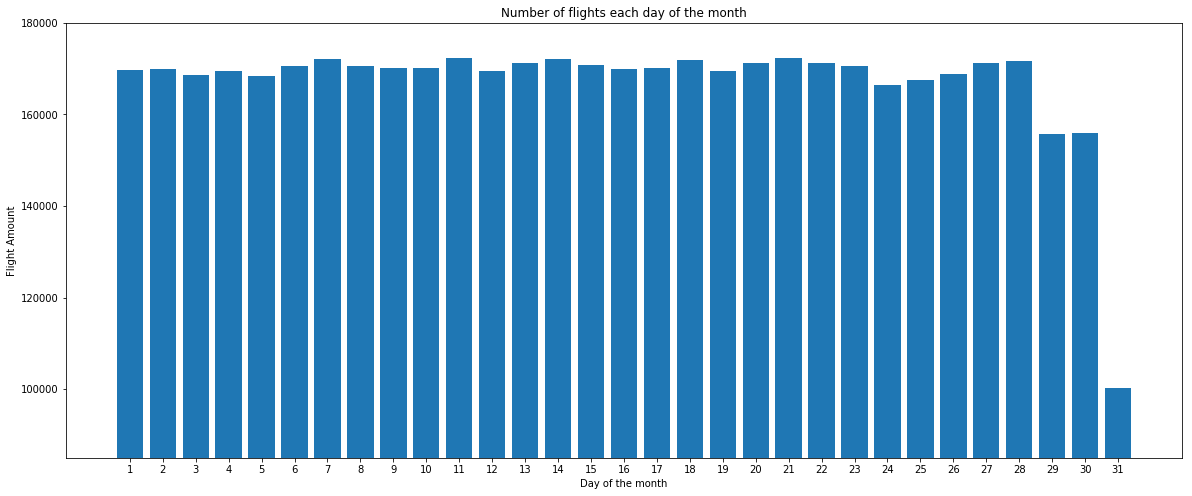

In [164]:
#Global statistics
import calendar
fig, ax = plt.subplots(figsize=(20,8))
style = dict(size=12, color='black', rotation=45)

indices = []
frequencies = []

for row in df.groupBy(df.day_of_month).count().orderBy('day_of_month' , ascending=1).collect():
    frequencies.append(row[1])
    indices.append(row[0])
    #ax.text(row[0], row[1], str('-->'+ str(row[1])), **style)

plt.bar(indices,frequencies, align="center")
axes = plt.gca()
axes.set_ylim([85000,180000])
axes.set_xticks(indices)
plt.title("Number of flights each day of the month")
plt.xlabel("Day of the month")
plt.ylabel("Flight Amount")
plt.show()

<div class="alert alert-success">
  Please realise the flight count on 31st is the least. And know that people are not scared or anything to fly on the last day of the month.<br>
  This is happening because not all months have a 31st day! Half of has 30 days. (February doesn't even have 29 and 30 in 1994)
</div>

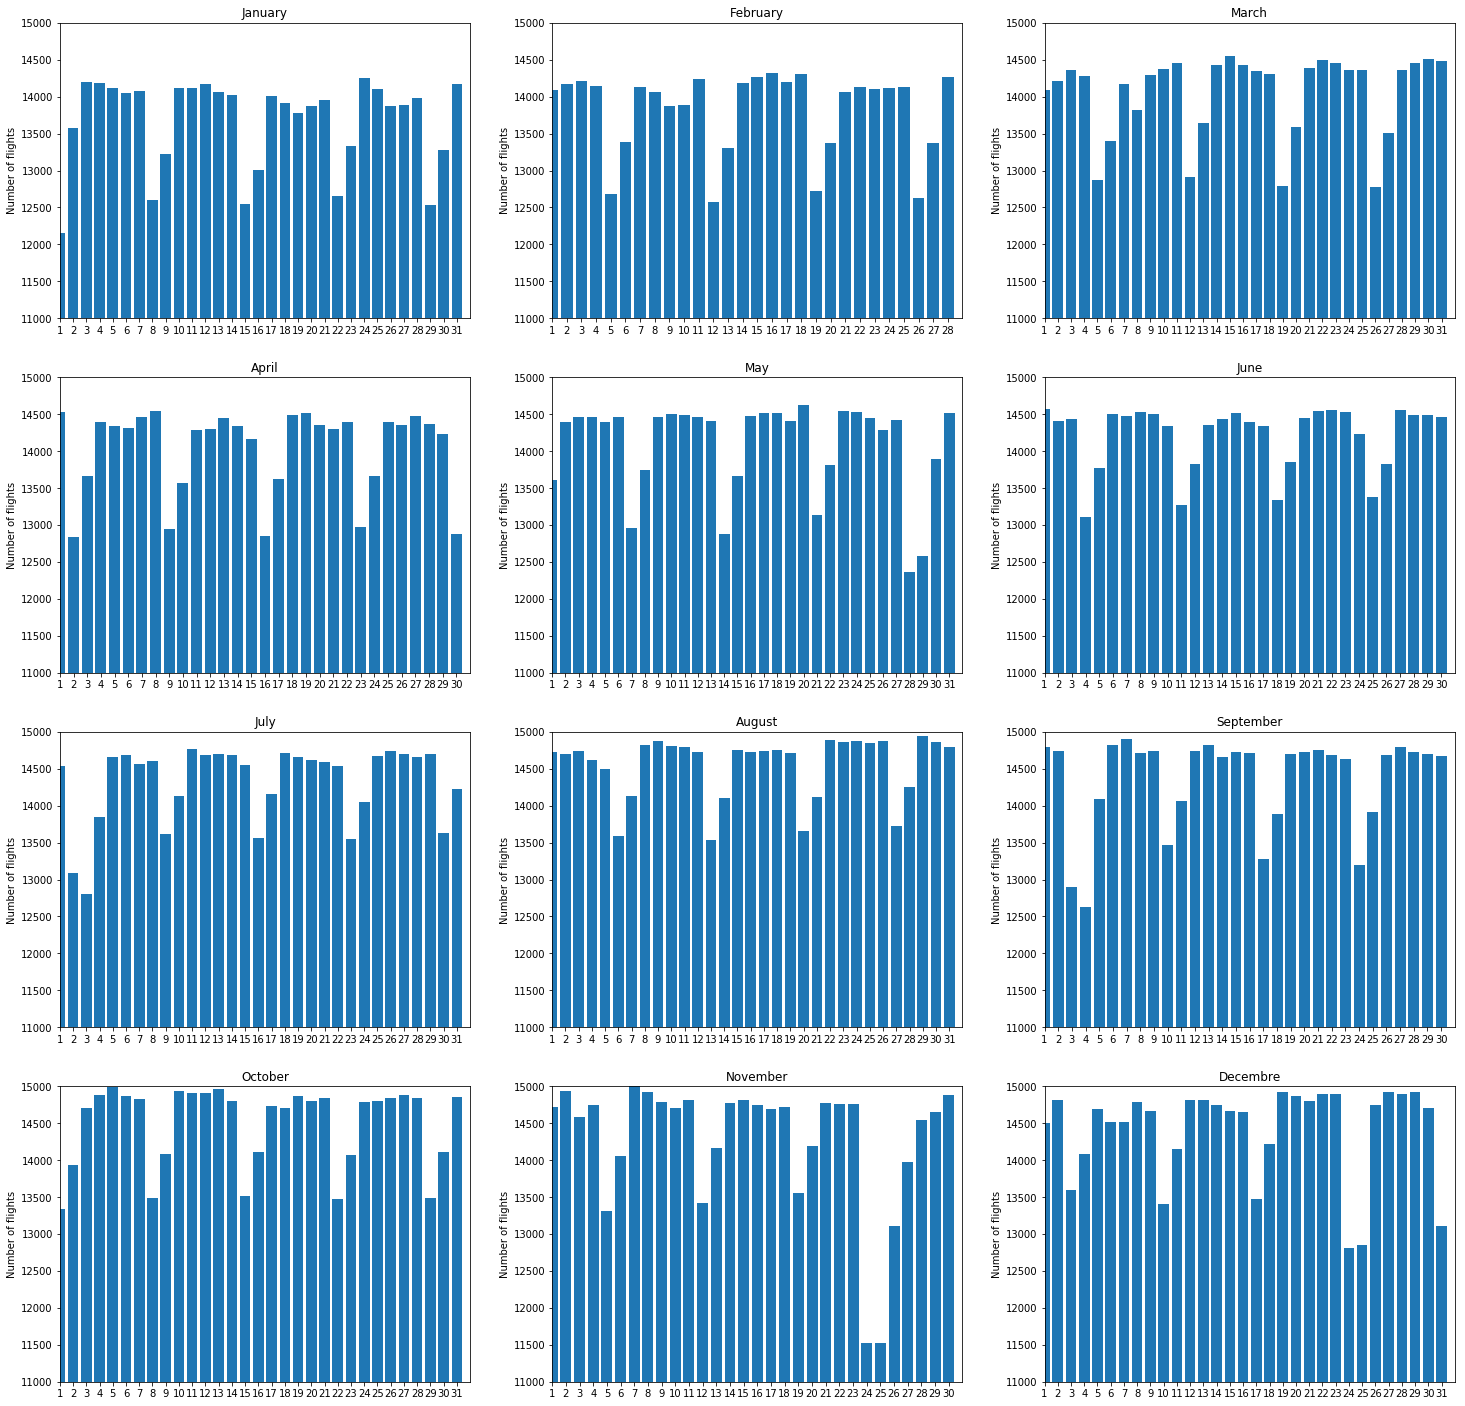

In [28]:
#Monthly statistics
months = [calendar.month_name[x+1] for x in range(12)]
days_month_count = df.groupBy(df.month, df.day_of_month).count().orderBy(df.month, df.day_of_month)

nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    monthly_counts = days_month_count[df.month == i+1].select('count').collect()
    plt.subplot(nr, nc, i+1)
    plt.bar([x for x in range(len(monthly_counts))], [x[0] for x in monthly_counts])
    plt.ylabel('Number of flights')
    plt.title(months[i])
    plt.xticks([p for p in range(len(monthly_counts))], [p+1 for p in range(len(monthly_counts))])
    plt.xlim(0, len(monthly_counts))
    plt.ylim([11000,15000])
plt.show()

<div class="alert alert-success">
From the first plot, representing the global statistics of number of flights each day of the month, we can see that the number are not that different in all days of the month, except the last days ( 30 and 31), which is expected because not of the months have the same number of days.
To go more into details, we used the monthly statistics: a plot for every month to see the variation of number of flights in every day of the month.
We can see each month with its exact number of days. Some world vacations, like 24/25 November, and 24/25 December and end of the year, we have less flights than in other days of the month.<br>
Small note: We used calendar.month_name for month names, and apperantly it is using British English so it prints Decembre instead of December.
</div>

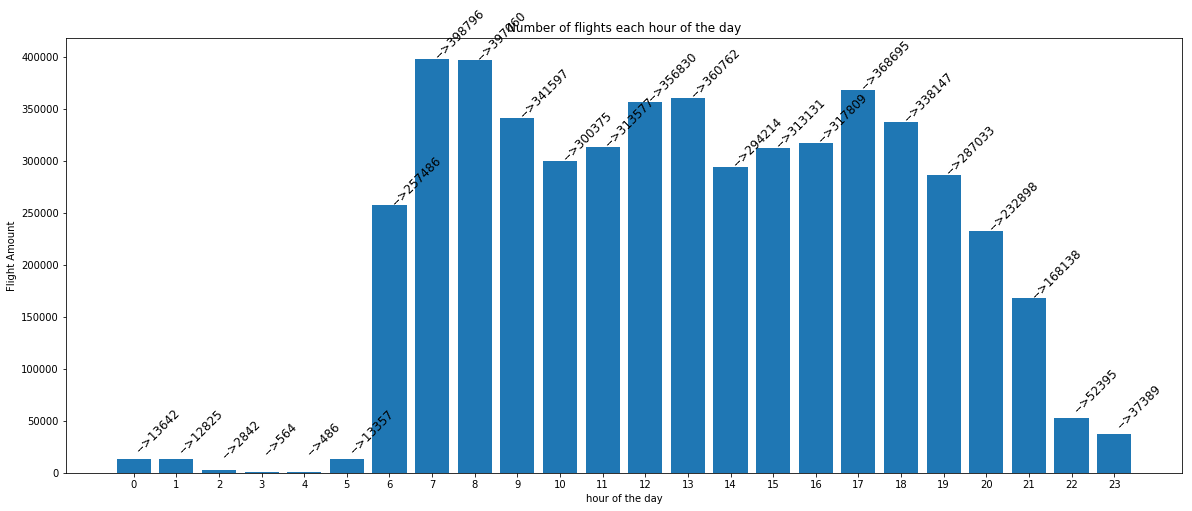

In [14]:
#Global statistics for the hour of the day 
import calendar
fig, ax = plt.subplots(figsize=(20,8))
style = dict(size=12, color='black', rotation=45)

indices = []
frequencies = []
#we need to add new column that gives us the hour of the day, based on the departure time 
df_hour = df.withColumn('hour_of_day', ((df.scheduled_departure_time/100).cast('int'))%24)

for row in df_hour.groupBy(df_hour.hour_of_day).count().orderBy('hour_of_day' , ascending=1).collect():
    frequencies.append(row[1])
    indices.append(row[0])
    ax.text(row[0], row[1]+40000, str('-->'+ str(row[1])), **style)

plt.bar(indices,frequencies, align="center")
axes = plt.gca()
axes.set_xticks(indices)
plt.title("Number of flights each hour of the day")
plt.xlabel("hour of the day")
plt.ylabel("Flight Amount")
plt.show()

<div class="alert alert-info">
  <strong>Info!</strong> Please notice we converted times from 0-2400 integers by removing their remainder from 100, dividing by 100 and modular to 24 into hours of the day. This way we get better histograms and understanding of the data we have.
</div>

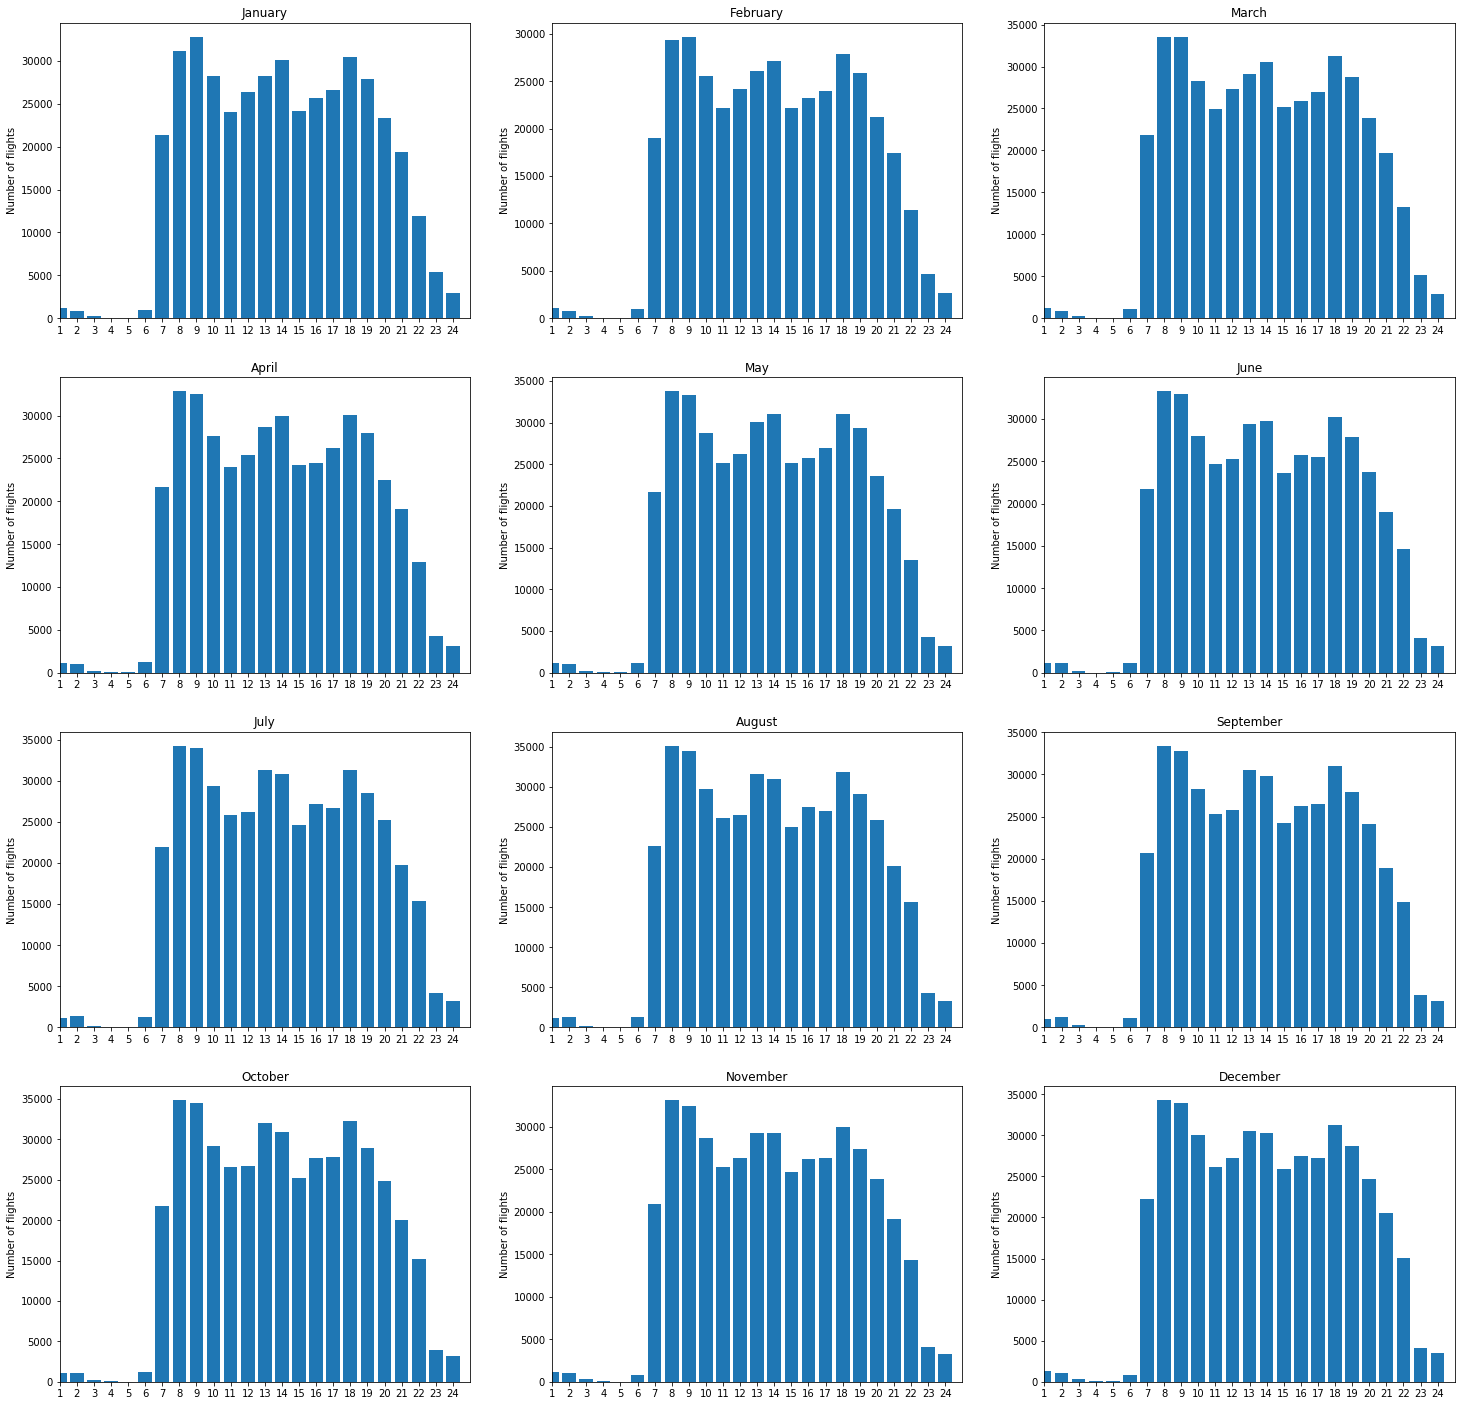

In [66]:
#Monthly statistics
months = [calendar.month_name[x+1] for x in range(12)]
hours_month_count = df_hour.groupBy(df_hour.month, df_hour.hour_of_day).count().orderBy(df_hour.month, df_hour.hour_of_day)
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    monthly_counts = hours_month_count[df.month == i+1].select('count').collect()
    plt.subplot(nr, nc, i+1)
    plt.bar([x for x in range(len(monthly_counts))], [x[0] for x in monthly_counts])
    plt.ylabel('Number of flights')
    plt.title(months[i])
    plt.xticks([p for p in range(len(monthly_counts))], [p+1 for p in range(len(monthly_counts))])
    plt.xlim(0, len(monthly_counts))
plt.show()

<div class="alert alert-success">
Global statistics of the hour of the day, shows us in the first plot the big variation of number of flights in a day. 
For the monthly statistics, we can see that from 22 to 5 pm, airport have less trafic comparing it to the other hour of the day.
Some hours like 8 am, 12 am and 5 pm has the highest number of flights, which can be considered as the rush hours, and can present risk of delays.
</div>

<div class="alert alert-warning">
  <strong>Our own question: </strong> We were just wondering what percentage of the flights are between 11pm and 7am as we can see they are very very little.
</div>

In [49]:
latenightflights = df[(df.scheduled_departure_time > 2300) | (df.scheduled_departure_time < 700)]
print ("There are " , latenightflights.count() ," flights between 11PM and 7AM which is", 100 * latenightflights.count() / float(df.count()), "% of total ",df.count() , " flights!")

There are  332819  flights between 11PM and 7AM which is 6.425017683233824 % of total  5180048  flights!


### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [10]:
Top20outbount = df.groupBy(df.src_airport).count().orderBy('count', ascending=0).head(20)
Top20outbount

[Row(src_airport='ORD', count=277741),
 Row(src_airport='DFW', count=256274),
 Row(src_airport='ATL', count=221486),
 Row(src_airport='LAX', count=153494),
 Row(src_airport='STL', count=151609),
 Row(src_airport='DEN', count=141427),
 Row(src_airport='PHX', count=139581),
 Row(src_airport='DTW', count=136837),
 Row(src_airport='PIT', count=130977),
 Row(src_airport='CLT', count=129391),
 Row(src_airport='MSP', count=123222),
 Row(src_airport='SFO', count=118233),
 Row(src_airport='EWR', count=116768),
 Row(src_airport='IAH', count=104182),
 Row(src_airport='LGA', count=101864),
 Row(src_airport='BOS', count=100365),
 Row(src_airport='LAS', count=94972),
 Row(src_airport='PHL', count=93585),
 Row(src_airport='DCA', count=88445),
 Row(src_airport='MCO', count=77120)]

In [11]:
Top20inbount = df.groupBy(df.dest_airport).count().orderBy('count', ascending=0).head(20)
Top20inbount

[Row(dest_airport='ORD', count=283720),
 Row(dest_airport='DFW', count=260249),
 Row(dest_airport='ATL', count=221588),
 Row(dest_airport='LAX', count=152959),
 Row(dest_airport='STL', count=152800),
 Row(dest_airport='DEN', count=144099),
 Row(dest_airport='PHX', count=140979),
 Row(dest_airport='DTW', count=139435),
 Row(dest_airport='PIT', count=131962),
 Row(dest_airport='CLT', count=130321),
 Row(dest_airport='MSP', count=124758),
 Row(dest_airport='SFO', count=117245),
 Row(dest_airport='EWR', count=117223),
 Row(dest_airport='IAH', count=104409),
 Row(dest_airport='LGA', count=101498),
 Row(dest_airport='BOS', count=99331),
 Row(dest_airport='LAS', count=94948),
 Row(dest_airport='PHL', count=93312),
 Row(dest_airport='DCA', count=87670),
 Row(dest_airport='MCO', count=76600)]

In [12]:
#sum of inbound and outbound flights
df_airport = df.withColumn('airport', df.src_airport).union(df.withColumn('airport', df.dest_airport))
Top20airport = df_airport.groupBy('airport').count().orderBy('count', ascending=0).head(20)
Top20airport

[Row(airport='ORD', count=561461),
 Row(airport='DFW', count=516523),
 Row(airport='ATL', count=443074),
 Row(airport='LAX', count=306453),
 Row(airport='STL', count=304409),
 Row(airport='DEN', count=285526),
 Row(airport='PHX', count=280560),
 Row(airport='DTW', count=276272),
 Row(airport='PIT', count=262939),
 Row(airport='CLT', count=259712),
 Row(airport='MSP', count=247980),
 Row(airport='SFO', count=235478),
 Row(airport='EWR', count=233991),
 Row(airport='IAH', count=208591),
 Row(airport='LGA', count=203362),
 Row(airport='BOS', count=199696),
 Row(airport='LAS', count=189920),
 Row(airport='PHL', count=186897),
 Row(airport='DCA', count=176115),
 Row(airport='MCO', count=153720)]

<BarContainer object of 20 artists>

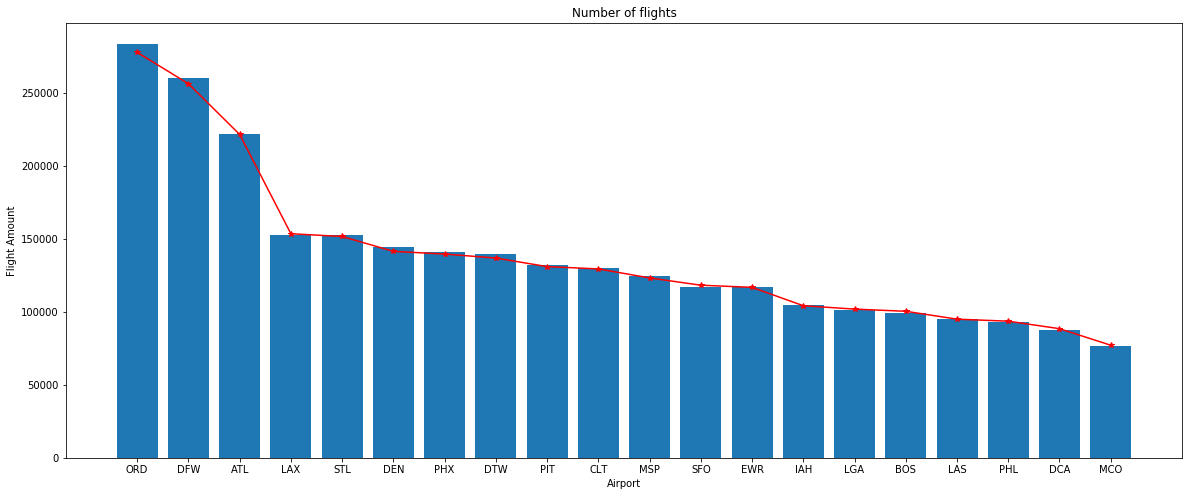

In [53]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title("Number of flights")
plt.xlabel("Airport")
plt.ylabel("Flight Amount")

countout = []
destairport = []
for row in Top20outbount:
    countout.append(row[1])
    destairport.append(row[0])
plt.plot(destairport,countout,'-*',c='r')
countin = []
srcairport = []
for row in Top20inbount:
    countin.append(row[1])
    srcairport.append(row[0])
#plt.plot(srcairport,countin,'-o',c='b')
plt.bar(srcairport, countin)

<div class="alert alert-success">
The top 20 busiest airports can be computed this in terms of the inbound, outbound and total number of flights. <br>
We noticed the top 3 busiest airports have very high flight numbers compared to the rest after 4th and so on. 
</div>

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [12]:
Top20carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0).head(20)
Top20carriers

[Row(carrier='DL', count=874526),
 Row(carrier='US', count=857906),
 Row(carrier='AA', count=722277),
 Row(carrier='UA', count=638750),
 Row(carrier='WN', count=565426),
 Row(carrier='CO', count=484834),
 Row(carrier='NW', count=482798),
 Row(carrier='TW', count=258205),
 Row(carrier='HP', count=177851),
 Row(carrier='AS', count=117475)]

<BarContainer object of 10 artists>

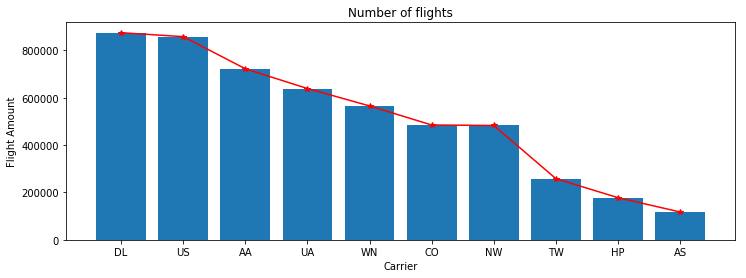

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
plt.title("Number of flights")
plt.xlabel("Carrier")
plt.ylabel("Flight Amount")

countout = []
carrier = []
for row in Top20carriers:
    countout.append(row[1])
    carrier.append(row[0])
plt.plot(carrier,countout,'-*',c='r')
plt.bar(carrier, countout)

## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

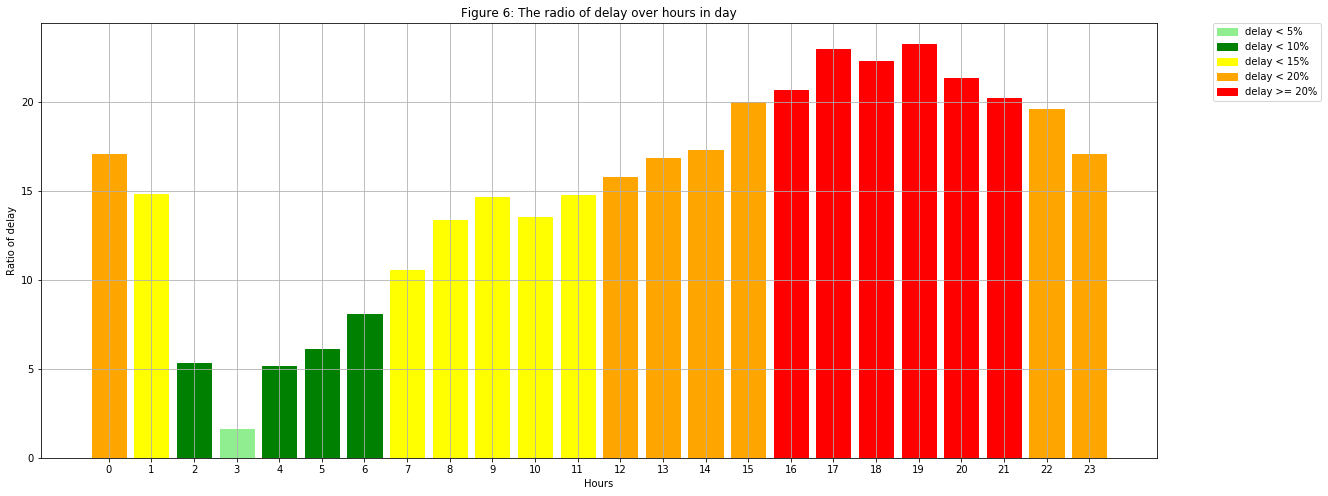

In [15]:
#delayedflights = df[(df.arrival_delay) >=15].collect()
#we can create a new column, 'delayed' , takes 1 if the flight is delayed and 0 if not
df_delay= df_hour.withColumn('delayed',func.when(df_hour["arrival_delay"] >= 15, 1).otherwise(0))
#we created a new alias "delay", that represents the percentage of delay of every hour. We calculated the delay by summing the values of delayed 
#of each hour (0 or 1), and then devide it by the total number of flights at that hour.
delayed_flights_perhour= df_delay.groupBy(['hour_of_day']).agg((100*func.sum('delayed')/func.count('*')).alias('delay')).orderBy('hour_of_day').collect()

fig, ax = plt.subplots(figsize=(20,8))
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(range(24), [x[1] for x in delayed_flights_perhour], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if delayed_flights_perhour[i][1] < 5:
        color = 'lightgreen'
    elif delayed_flights_perhour[i][1] < 10:
        color = 'green'
    elif delayed_flights_perhour[i][1] < 15:
        color = 'yellow'
    elif delayed_flights_perhour[i][1] < 20:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
patch2 = mpatches.Patch(color='green', label='delay < 10%')
patch3 = mpatches.Patch(color='yellow', label='delay < 15%')
patch4 = mpatches.Patch(color='orange', label='delay < 20%')
patch5 = mpatches.Patch(color='red', label='delay >= 20%')
plt.xticks(range(24))
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<div class="alert alert-success">
  Well, we were right about flights not being delayed that much during night times. <br>
  Most longest delays occur during evening hours because the airport is the busiest during which we have seen earlier.
</div>

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

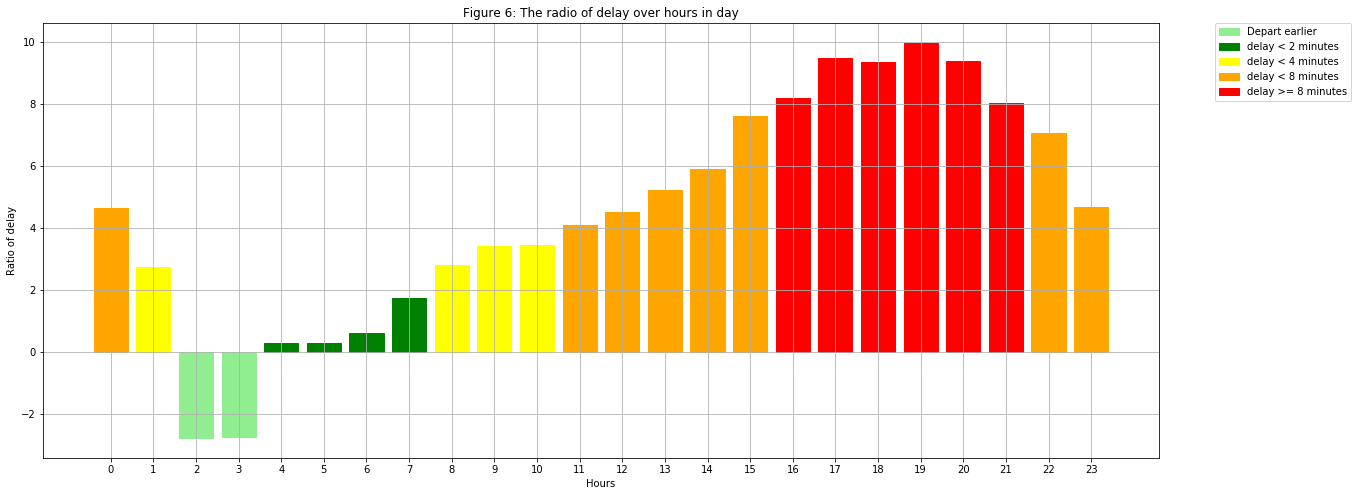

In [16]:
df_delays_avg = df_hour.groupBy('hour_of_day').avg('arrival_delay').orderBy('hour_of_day').collect()
    
# PLOT
fig, ax = plt.subplots(figsize=(20,8))

plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar([x for x in range(len(df_delays_avg))], [x[1] for x in df_delays_avg],align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if df_delays_avg[i][1] < 0:
        color = 'lightgreen'
    elif df_delays_avg[i][1] < 2:
        color = 'green'
    elif df_delays_avg[i][1] < 4:
        color = 'yellow'
    elif df_delays_avg[i][1] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')
plt.xticks(range(24))
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<div class="alert alert-success">
 In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule.<br>
 In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.<br>
<br>
This example shows us that the way representing results are also important.
</div>

### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

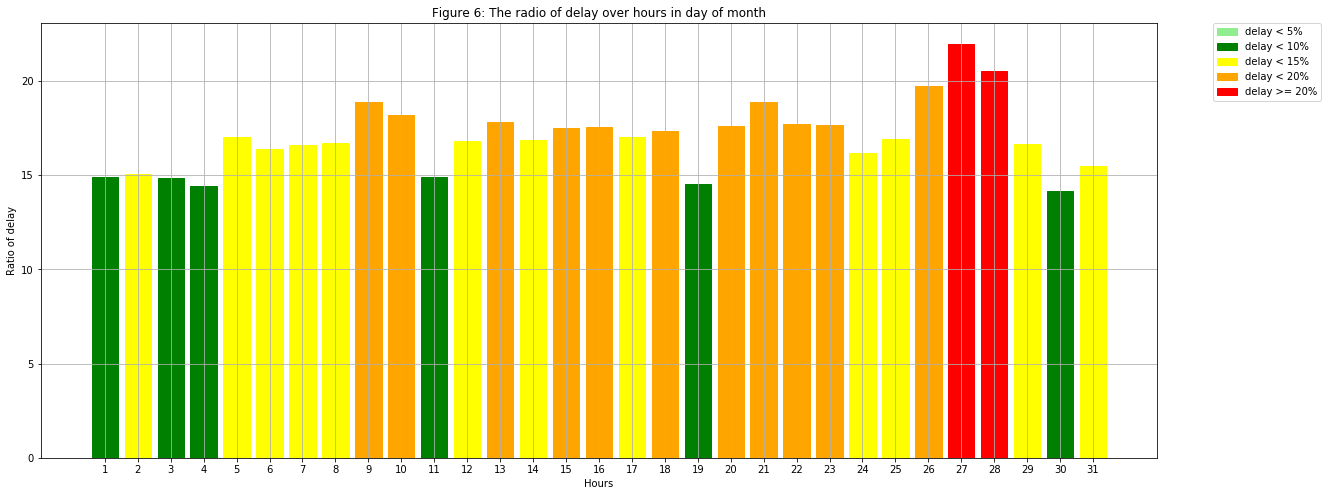

In [17]:
# for the percentage, we do like we did in 4.1, bu in this question e should focus on the day of the month.
delays_dayofmonth = df_delay.groupBy(['day_of_month']).agg((100*func.sum('delayed')/func.count('*')).alias('delay_ratio')).orderBy('day_of_month').collect()

# PLOT
fig, ax = plt.subplots(figsize=(20,8))

plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day of month')
plt.grid(True,which="both",ls="-")
bars = plt.bar([x+1 for x in range(len(delays_dayofmonth))], [x[1] for x in delays_dayofmonth],align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if delays_dayofmonth[i][1] < 10:
        color = 'lightgreen'
    elif delays_dayofmonth[i][1] < 15:
        color = 'green'
    elif delays_dayofmonth[i][1] < 17:
        color = 'yellow'
    elif delays_dayofmonth[i][1] < 20:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
patch2 = mpatches.Patch(color='green', label='delay < 10%')
patch3 = mpatches.Patch(color='yellow', label='delay < 15%')
patch4 = mpatches.Patch(color='orange', label='delay < 20%')
patch5 = mpatches.Patch(color='red', label='delay >= 20%')
plt.xticks([x+1 for x in range(len(delays_dayofmonth))])
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<div class="alert alert-success">
We can see  from the global statistics over a year, that there are delays in average every day of the month, an average between 15 to 20%. Sure it varies from a month to another. Going more into the details of each month, will give us the exact delays of each day of the month.
</div>

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

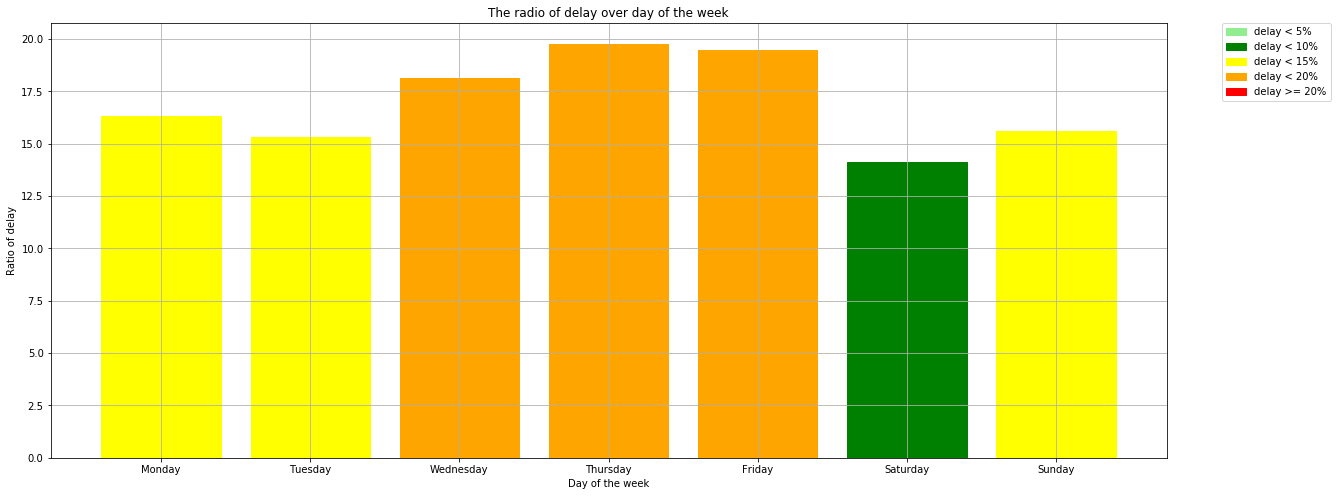

In [18]:
import calendar
# for the percentage, we do like we did in 4.1, bu in this question e should focus on the day of the month.
delays_dayofweek = df_delay.groupBy(['day_of_week']).agg((100*func.sum('delayed')/func.count('*')).alias('delay_ratio')).orderBy('day_of_week').collect()

# PLOT
fig, ax = plt.subplots(figsize=(20,8))

plt.xlabel("Day of the week")
plt.ylabel("Ratio of delay")
plt.title('The radio of delay over day of the week')
plt.grid(True,which="both",ls="-")
bars = plt.bar([x+1 for x in range(len(delays_dayofweek))], [x[1] for x in delays_dayofweek],align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if delays_dayofweek[i][1] < 10:
        color = 'lightgreen'
    elif delays_dayofweek[i][1] < 15:
        color = 'green'
    elif delays_dayofweek[i][1] < 17:
        color = 'yellow'
    elif delays_dayofweek[i][1] < 20:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
patch2 = mpatches.Patch(color='green', label='delay < 10%')
patch3 = mpatches.Patch(color='yellow', label='delay < 15%')
patch4 = mpatches.Patch(color='orange', label='delay < 20%')
patch5 = mpatches.Patch(color='red', label='delay >= 20%')
days_of_week = list(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks([x+1 for x in range(len(days_of_week))], days_of_week)
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<div class="alert alert-success">
Globally, we can see that delays in average are always less than 20% over the days of a week. Even less for the weekend (less than 15%). As for previous question, when we expected to have high number of flights on the weekend, we expected for this case also to have highest delays on the weekend. But we can see that is not the case. For sure that the delay varies from a week to another, depending on the month and several other factors. 
</div>

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

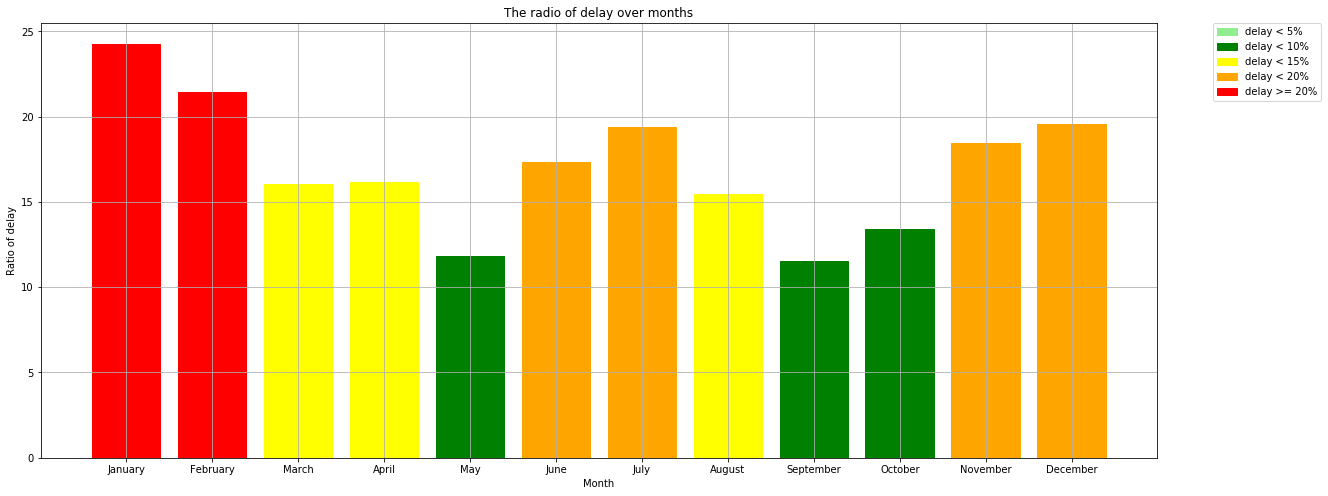

In [19]:
import calendar
# for the percentage, we do like we did in 4.1, bu in this question e should focus on the day of the month.
delays_months = df_delay.groupBy(['month']).agg((100*func.sum('delayed')/func.count('*')).alias('delay_ratio')).orderBy('month').collect()

# PLOT
fig, ax = plt.subplots(figsize=(20,8))

plt.xlabel("Month")
plt.ylabel("Ratio of delay")
plt.title('The radio of delay over months')
plt.grid(True,which="both",ls="-")
bars = plt.bar([x+1 for x in range(len(delays_months))], [x[1] for x in delays_months],align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if delays_months[i][1] < 10:
        color = 'lightgreen'
    elif delays_months[i][1] < 15:
        color = 'green'
    elif delays_months[i][1] < 17:
        color = 'yellow'
    elif delays_months[i][1] < 20:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
patch2 = mpatches.Patch(color='green', label='delay < 10%')
patch3 = mpatches.Patch(color='yellow', label='delay < 15%')
patch4 = mpatches.Patch(color='orange', label='delay < 20%')
patch5 = mpatches.Patch(color='red', label='delay >= 20%')
months = [calendar.month_name[x+1] for x in range(12)]
plt.xticks([x+1 for x in range(len(months))], months)
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<div class="alert alert-success">
Delays varies from a month to another, which is normal as we have seen the delay per week on the day and per day of the month. The months with highest delays are winter months (december, January, February). It can be somehow related to the weather. And also, we can see that summer month have quiet high delays, which is maybe due to high trafic of travelling during summer vacation.
</div>

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [11]:
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

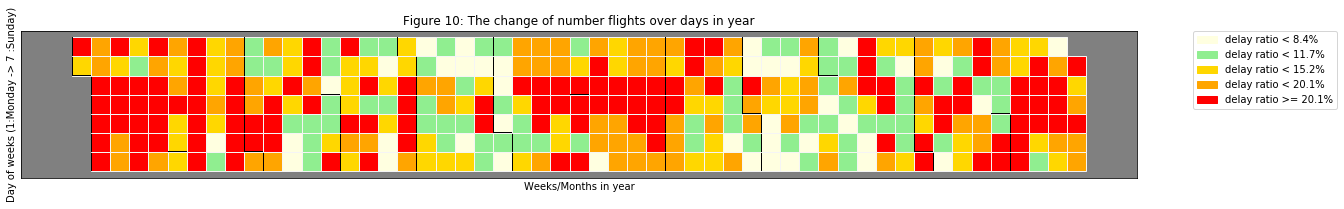

In [21]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

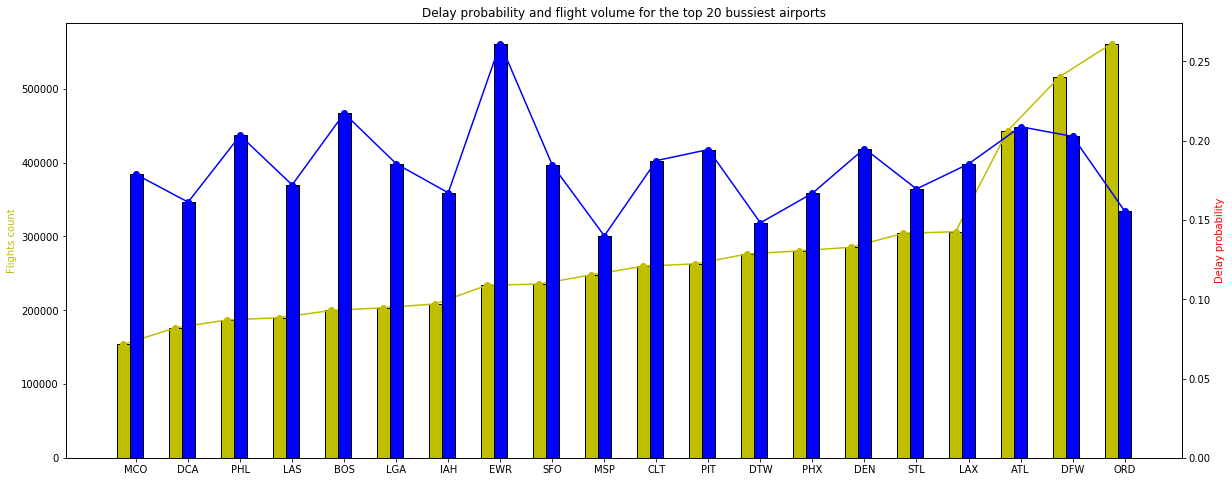

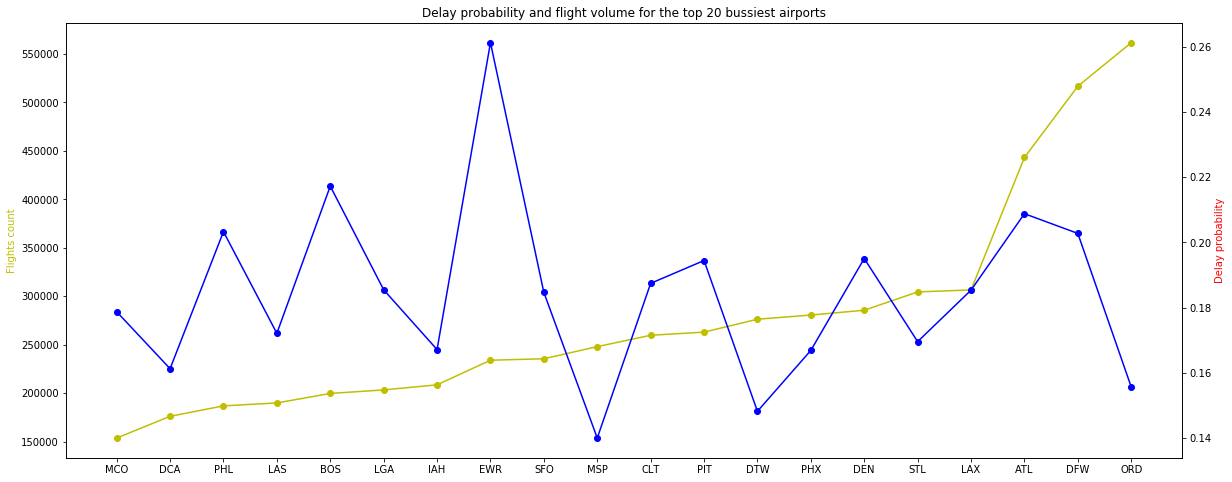

In [5]:
#the flight volume of each airport
#since we have a different number of inbound and outbount flights, it is better if we join both in one new attribute.
df_airport = df.withColumn('airport', df.src_airport).union(df.withColumn('airport', df.dest_airport))
TopAirport_volumes = df_airport.groupBy('airport').count().orderBy('count', ascending=0)
Top20Airport_volumes = TopAirport_volumes.take(20)

#the associated delay of each airport in the top 20 
df_airport_delay = df_airport.filter(df_airport.airport.isin([x[0] for x in Top20Airport_volumes]))
df_airport_delay=df_airport_delay.withColumn('delay', func.when((df["arrival_delay"] >= 15), 1).otherwise(0))
airport_delay = df_airport_delay.groupBy('airport').agg((func.sum('delay')/func.count('*')).alias('delay_ratio')).orderBy('delay_ratio')

#Join the previous dfs based on the the attribue 'airport'
joined_data = TopAirport_volumes.join(airport_delay, on='airport').select('*').orderBy('count').collect()

# PLOT bar chart 
fig, ax = plt.subplots(figsize=(20,8))
ax.bar([x for x in range(len(joined_data))], [x[1] for x in joined_data], 0.25, edgecolor = "black", color = 'y')
ax.plot([x for x in range(len(joined_data))], [x[1] for x in joined_data], marker='o',color = 'y')
ax.set_ylabel('Flights count', color='y')
ax2 = ax.twinx()
bars_delay = plt.bar([x+0.25 for x in range(len(joined_data))], [x[2] for x in joined_data], 0.25, edgecolor = "black",  color = 'b')
bars_delay = plt.plot([x+0.25 for x in range(len(joined_data))], [x[2] for x in joined_data],marker='o', color = 'b')
ax2.set_ylabel('Delay probability', color='r')

plt.xticks([x+0.25 for x in range(len(joined_data))], [x[0] for x in joined_data])
plt.title('Delay probability and flight volume for the top 20 bussiest airports')
plt.show()

# PLOT line chart 
fig, ax = plt.subplots(figsize=(20,8))
ax.plot([x for x in range(len(joined_data))], [x[1] for x in joined_data], marker='o',color = 'y')
ax.set_ylabel('Flights count', color='y')
ax2 = ax.twinx()
bars_delay = plt.plot([x for x in range(len(joined_data))], [x[2] for x in joined_data],marker='o', color = 'b')
ax2.set_ylabel('Delay probability', color='r')

plt.xticks([x for x in range(len(joined_data))], [x[0] for x in joined_data])
plt.title('Delay probability and flight volume for the top 20 bussiest airports')
plt.show()


<div class="alert alert-success">
We can see from the figures, the bar and the line char of flights volumes and delays per top 20 bussiest airports, that there is not a clear correlation between the delay probability and the flight volume in an airport.
We expected the opposite, a logic correlation and increase of delays when the airport is busy, but it is not the case. So having a large volume of flight is not the direct cause of the delay, it may contribute a bit, but really small contribution since we can't see it cleary in these figures.
</div>

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!
<div class="label label-success">SUGGESTION </div>  
    You can try with different chart type to have a better visualization.
</div>

<div class="alert alert-success">
  There were only 10 carriers in 1994 dataset, so we will answer this question for 10 of them. If you were asking for all years it is the same procedure anyways.
</div>

In [14]:
#Flight count for each carrier
Topcarriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0)
Topcarriers.show()

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



<div class="alert alert-success">
  <strong>Step 1:</strong> We extract the total flight counts of these carriers. These numbers will be used to divide the delayed flight counts in the end
</div>

In [21]:
#the associated delay of each airport related to the busiest carrier : 'DL'
df_airport_1_carrier = df_airport.filter(df_airport.carrier == Topcarriers.take(1)[0].carrier)
TopAirport_volumes_1_carrier = df_airport_1_carrier.groupBy('airport').count().orderBy('count', ascending=0)
TopAirport_volumes_1_carrier.show()

+-------+------+
|airport| count|
+-------+------+
|    ATL|355769|
|    DFW|151577|
|    CVG|116868|
|    SLC|107828|
|    LAX| 49824|
|    MCO| 46613|
|    LGA| 46344|
|    BOS| 39829|
|    DCA| 29973|
|    FLL| 21750|
|    TPA| 20736|
|    SFO| 18707|
|    PHX| 18587|
|    JFK| 18285|
|    PBI| 17930|
|    ORD| 17859|
|    MIA| 17387|
|    MSY| 17045|
|    LAS| 15573|
|    SEA| 15383|
+-------+------+
only showing top 20 rows



<div class="alert alert-success">
  <strong>Step 2:</strong> This is an inner stage to show our progress: For the top carrier DL, we extract all flight counts to all airports in the dataset. As it works for DL we can now loop all carriers for per airport on the next step
</div>

In [22]:
#Similarly now we find the delay of ALL airports and sum the tables like above together
df_airport_delay = df_airport_1_carrier.filter(df_airport.airport.isin([x[0] for x in TopAirport_volumes_1_carrier.take(20)]))
df_airport_delay=df_airport_delay.withColumn('delay', func.when((df["arrival_delay"] >= 15), 1).otherwise(0))
airport_delay = df_airport_delay.groupBy('airport').agg((func.sum('delay')/func.count('*')).alias('delay_ratio')).orderBy('delay_ratio')
airport_delay.show()

+-------+-------------------+
|airport|        delay_ratio|
+-------+-------------------+
|    MSY|0.13851569375183337|
|    DCA|0.15817569145564342|
|    LGA|0.16135853616433626|
|    MCO|0.16514706197841802|
|    SLC|0.16681195978781022|
|    ORD|0.16837448905313848|
|    CVG|0.17025190813567442|
|    PHX|0.17033410448162695|
|    TPA| 0.1736593364197531|
|    LAS| 0.1774866756565851|
|    DFW|0.18445410583399857|
|    PBI|0.18466257668711655|
|    BOS|0.19862411810489844|
|    SFO|0.19869567541561983|
|    LAX| 0.2002850032113038|
|    ATL|0.20742110751639406|
|    SEA|0.21991809139959695|
|    MIA| 0.2321274515442572|
|    FLL| 0.2365057471264368|
|    JFK| 0.2627290128520645|
+-------+-------------------+



<div class="alert alert-success">
  <strong>Step 3:</strong> For all airports, we create a new column called 'delay' and put 1 for delayed and 0 for not. Then we sum the amount of delays(basically 1's defining delay), and dividing it by the total count of flight to that airport we can calculate the percentage delay per airport.
</div>

In [23]:
#Join the previous dfs based on the the attribue 'airport'
joined_data_1_carrier = TopAirport_volumes_1_carrier.join(airport_delay, on='airport').select('*').orderBy('count')
joined_data_1_carrier.show()
joined_data_1_carrier= joined_data_1_carrier.collect()

+-------+------+-------------------+
|airport| count|        delay_ratio|
+-------+------+-------------------+
|    SEA| 15383|0.21991809139959695|
|    LAS| 15573| 0.1774866756565851|
|    MSY| 17045|0.13851569375183337|
|    MIA| 17387| 0.2321274515442572|
|    ORD| 17859|0.16837448905313848|
|    PBI| 17930|0.18466257668711655|
|    JFK| 18285| 0.2627290128520645|
|    PHX| 18587|0.17033410448162695|
|    SFO| 18707|0.19869567541561983|
|    TPA| 20736| 0.1736593364197531|
|    FLL| 21750| 0.2365057471264368|
|    DCA| 29973|0.15817569145564342|
|    BOS| 39829|0.19862411810489844|
|    LGA| 46344|0.16135853616433626|
|    MCO| 46613|0.16514706197841802|
|    LAX| 49824| 0.2002850032113038|
|    SLC|107828|0.16681195978781022|
|    CVG|116868|0.17025190813567442|
|    DFW|151577|0.18445410583399857|
|    ATL|355769|0.20742110751639406|
+-------+------+-------------------+



<div class="alert alert-success">
  <strong>Step 4:</strong> We concat the delayed flight counts to the percentage table. This is important because notice, MSY airport actually delayed more flights in amount than SEA, but in percentage it is the 3rd one.
</div>

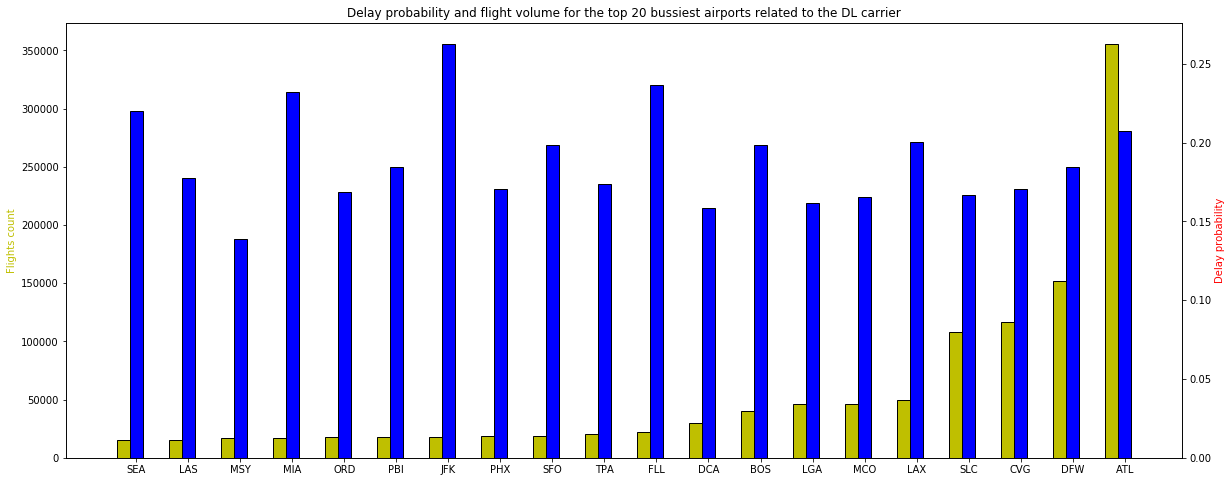

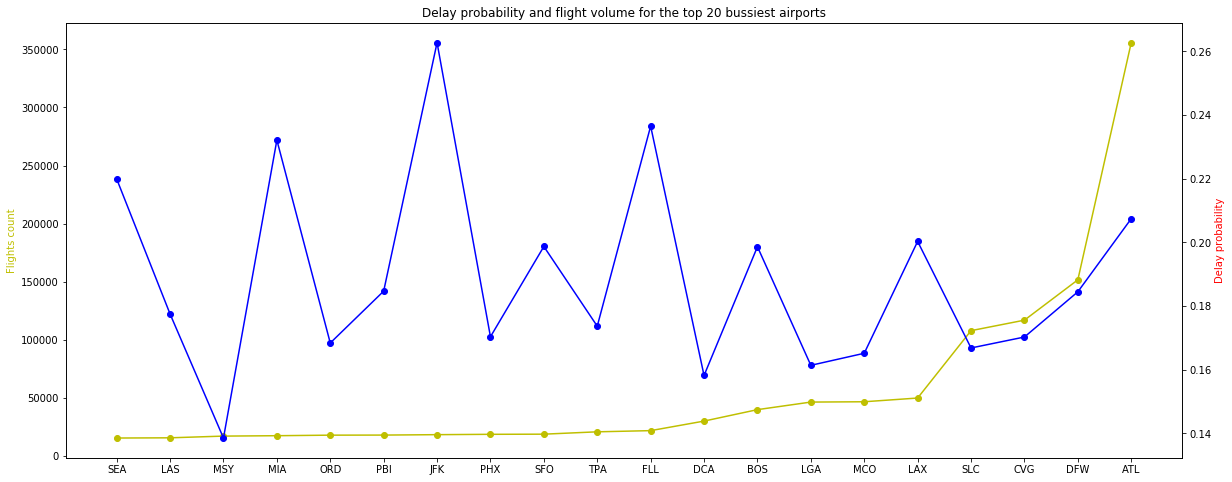

In [24]:
# PLOT
fig, ax = plt.subplots(figsize=(20,8))
ax.bar([x for x in range(len(joined_data_1_carrier))], [x[1] for x in joined_data_1_carrier], 0.25, edgecolor = "black", color = 'y')
ax.set_ylabel('Flights count', color='y')
ax2 = ax.twinx()
bars_delay = plt.bar([x+0.25 for x in range(len(joined_data_1_carrier))], [x[2] for x in joined_data_1_carrier], 0.25, edgecolor = "black",  color = 'b')
ax2.set_ylabel('Delay probability', color='r')

plt.xticks([x+0.25 for x in range(len(joined_data_1_carrier))], [x[0] for x in joined_data_1_carrier])
plt.title('Delay probability and flight volume for the top 20 bussiest airports related to the DL carrier')
plt.show()

# PLOT line chart 
fig, ax = plt.subplots(figsize=(20,8))
ax.plot([x for x in range(len(joined_data_1_carrier))], [x[1] for x in joined_data_1_carrier], marker='o',color = 'y')
ax.set_ylabel('Flights count', color='y')
ax2 = ax.twinx()
bars_delay = plt.plot([x for x in range(len(joined_data_1_carrier))], [x[2] for x in joined_data_1_carrier],marker='o', color = 'b')
ax2.set_ylabel('Delay probability', color='r')

plt.xticks([x for x in range(len(joined_data_1_carrier))], [x[0] for x in joined_data_1_carrier])
plt.title('Delay probability and flight volume for the top 20 bussiest airports')
plt.show()

<div class="alert alert-success">
The top carrier in terms of flight count is DL, so we had worked on the top 20 airports related to this carrier. Again, we can not see a clear correlation between flight volumes and delay probabitities.
</div>

<div class="alert alert-success">
  <strong>Step 5:</strong> We sort the probabilities and plot them here to show that airport ATL has the highest delay probability, but not the airport that has the highest amount of delays in the end. Still the sudden jump between 2nd one to 1st is very high meaning there is something wrong with the process of ATL airport that causes flight delays. Maybe weather, maybe functional problems.
</div>

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+

+-------+------+-------------------+
|carrier| count|        delay_ratio|
+-------+------+-------------------+
|     AS|117475| 0.1596424771227921|
|     HP|177851|0.18625141269939444|
|     TW|258205|0.18212273193780135|
|     NW|482798| 0.1294806523639286|
|     CO|484834| 0.1955576547849367|
|     WN|565426|0.12829795587751536|
|     UA|638750| 0.1686528375733855|
|     AA|722277| 0.1752444006939166|
|     US|857906|0.18422298014001534|
|     DL|874526|0.18328443065157582|
+-------+------+-------------------+



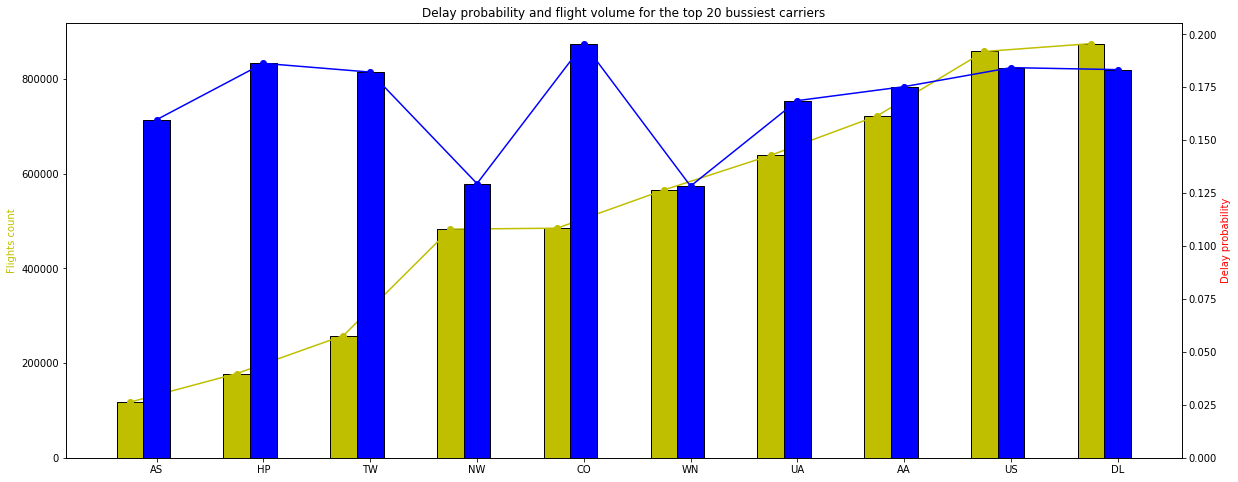

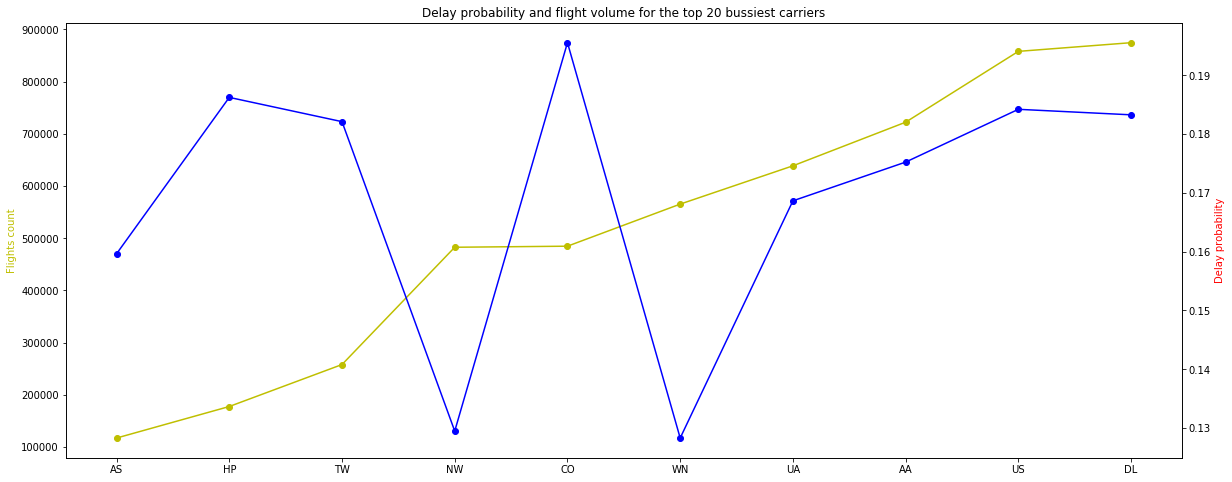

In [6]:
Topcarriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0)
Topcarriers.show()

#the associated delay of each carrier in the top 20 
df_carrier_delay = df_airport.filter(df_airport.carrier.isin([x[0] for x in Topcarriers.take(20)]))
df_carrier_delay=df_carrier_delay.withColumn('delay', func.when((df["arrival_delay"] >= 15), 1).otherwise(0))
carrier_delay = df_carrier_delay.groupBy('carrier').agg((func.sum('delay')/func.count('*')).alias('delay_ratio')).orderBy('delay_ratio')

#Join the previous dfs based on the the attribue 'carrier'
joined_data_carrier = Topcarriers.join(carrier_delay, on='carrier').select('*').orderBy('count')
joined_data_carrier.show()
joined_data_carrier= joined_data_carrier.collect()


# PLOT bar chart 
fig, ax = plt.subplots(figsize=(20,8))
ax.bar([x for x in range(len(joined_data_carrier))], [x[1] for x in joined_data_carrier], 0.25, edgecolor = "black", color = 'y')
ax.plot([x for x in range(len(joined_data_carrier))], [x[1] for x in joined_data_carrier], marker='o',color = 'y')
ax.set_ylabel('Flights count', color='y')
ax2 = ax.twinx()
bars_delay = plt.bar([x+0.25 for x in range(len(joined_data_carrier))], [x[2] for x in joined_data_carrier], 0.25, edgecolor = "black",  color = 'b')
bars_delay = plt.plot([x+0.25 for x in range(len(joined_data_carrier))], [x[2] for x in joined_data_carrier],marker='o', color = 'b')
ax2.set_ylabel('Delay probability', color='r')

plt.xticks([x+0.25 for x in range(len(joined_data_carrier))], [x[0] for x in joined_data_carrier])
plt.title('Delay probability and flight volume for the top 20 bussiest carriers')
plt.show()



# PLOT line chart 
fig, ax = plt.subplots(figsize=(20,8))
ax.plot([x for x in range(len(joined_data_carrier))], [x[1] for x in joined_data_carrier], marker='o',color = 'y')
ax.set_ylabel('Flights count', color='y')
ax2 = ax.twinx()
bars_delay = plt.plot([x for x in range(len(joined_data_carrier))], [x[2] for x in joined_data_carrier],marker='o', color = 'b')
ax2.set_ylabel('Delay probability', color='r')

plt.xticks([x for x in range(len(joined_data_carrier))], [x[0] for x in joined_data_carrier])
plt.title('Delay probability and flight volume for the top 20 bussiest carriers')
plt.show()



<div class="alert alert-success">
In this last part, we worked on flights counts and delays for the top 20 carriers. We can see clearly that the bussiest carrier 'DL', has a high delay. But still, we can not establish a relation between Carrier and delays.
</div>

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

In this part we are using the whole dataset of airline that is related to different years from 1987 to 2007 and we will clean it as we did for the first part.

In [4]:
# generate the complete dataframe considering all the csv files in HDFS
all_df = sc.textFile('/datasets/airline/*.csv')
# extract the header
header = all_df.first()

# replace invalid data with NULL and remove header
cleaned_data_all = (
        
        # filter out the header
        all_df.filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns_all = (
    cleaned_data_all.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df_all = sqlContext.createDataFrame(cleaned_data_to_columns_all, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()


df_all.printSchema()


root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [5]:
src_airports = df_all.select(df_all.src_airport)
dest_airports = df_all.select(df_all.dest_airport)

# airports that are only as destination
onlydest = dest_airports.subtract(src_airports)

# airports that are only as source
onlysource = src_airports.subtract(dest_airports)

In [6]:
print("Only destination airports:")
onlydest.show()

Only destination airports:
+------------+
|dest_airport|
+------------+
|         RCA|
|         LBF|
|         MKC|
|         LAR|
|         CBM|
|         SKA|
+------------+



In [7]:
print("Only source airports:")
onlysource.show()

Only source airports:
+-----------+
|src_airport|
+-----------+
+-----------+



There were some only source airports when we used only 1994, but apperantly when we expand to all years from 1987 those airports were destinations in the earlier years. Thus, the list became empty meaning eventually all airports in the dataset was used as a destination.

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

In [44]:
#We create is_delay that is either 1 or 0 depending on if flight delayed.
df_with_delay = df_all.withColumn('is_delay', func.when(df_all["arrival_delay"] >= 15, 1).otherwise(0))

#Then we group them and mean the delays
print("Top 10 airports that has the highest probability of delays being SOURCES:")
inner_delays=df_with_delay.groupBy('src_airport').agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio')).orderBy('delay_ratio')
inner_delays.show(10)

#Then we group them and mean the delays
print("Top 10 airports that has the highest probability of delays being DESTINATIONS:")
outer_delays=df_with_delay.groupBy("dest_airport").agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio')).orderBy('delay_ratio')
outer_delays.show(10)

#Now we can combine them together and calculate a mean of both arrivals and departures.
print("Top 10 airports that has the highest probability of delays COMBINED:")
combined_delaysdf = pd.DataFrame(inner_delays.collect() + outer_delays.collect())
combined_delaysdf.columns = ['airport','delay_probability']
combined_delays = combined_delaysdf.groupby("airport").mean().sort_values(by="delay_probability",ascending=0)
combined_delays.head(10)

Top 10 airports that has the highest probability of delays being SOURCES:
+-----------+--------------------+
|src_airport|         delay_ratio|
+-----------+--------------------+
|        PVU|                 0.0|
|        MKK|0.006920415224913495|
|        LNY| 0.01384083044982699|
|        INL|0.013888888888888888|
|        FOE|0.017543859649122806|
|        SLE|0.047325102880658436|
|        VIS| 0.04867034621174109|
|        PUB|0.055531199766184425|
|        IYK| 0.06296296296296296|
|        RDR| 0.06521739130434782|
+-----------+--------------------+
only showing top 10 rows

Top 10 airports that has the highest probability of delays being DESTINATIONS:
+------------+-----------+
|dest_airport|delay_ratio|
+------------+-----------+
|         SKA|        0.0|
|         CBM|        0.0|
|         BFF|        0.0|
|         BFI|        0.0|
|         LAR|        0.0|
|         FMN|        0.0|
|         OGD|        0.0|
|         MKC|        0.0|
|         RCA|        0.0|
|      

,delay_probability
airport,
FMN,0.500000
BFF,0.500000
CYS,0.500000
BFI,0.500000
OTH,0.419540
OGD,0.416667
ILG,0.366692
ACK,0.352153
ADK,0.328189


Part 2: City delays

In [14]:
#Create DataFrame for cities

df_cities = sqlContext.read.load('../datasets/airline/airports.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

In [21]:
#Calculate the average delay duration and sort the results
delay_cities=df.join(df_cities, df.dest_airport==df_cities.iata, "inner").groupBy(df_cities.city).agg(func.avg(df.arrival_delay).alias("avg_delay")).orderBy("avg_delay", ascending=0)
delay_cities.show(10)

+--------------+------------------+
|          city|         avg_delay|
+--------------+------------------+
|     Nantucket|              20.0|
|      Montrose|17.352941176470587|
|   Bakersfield|13.368070953436806|
|        Newark|12.523816300934863|
|     Lafayette| 11.64069264069264|
|    St. Mary's|11.181818181818182|
|     Aguadilla| 10.39760837070254|
|    Petersburg|10.231907894736842|
|Grand Junction|10.088669950738916|
|      Gunnison|10.014218009478673|
+--------------+------------------+
only showing top 10 rows



### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>

<div class="alert alert-danger">
  <strong>STUCK!</strong> Weather dataset needed. We couldn't download it from the web page, and it is not in our ZOE directory :(
    <br>
    TODO: if time left, we will try to find some other weather dataset from 1994 or generate a dummy dataset and work on it.
</div>